## Miniproject 2: MovieLens Visualization



### Download data

In [40]:
import requests

url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [42]:
def grad_U(Ui, Yij, Vj, reg, eta,ai,bj,global_bias):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-reg*eta)*Ui + eta * Vj * (Yij -global_bias - np.dot(Ui,Vj)+ai+bj)     

def grad_V(Vj, Yij, Ui, reg, eta,ai,bj,global_bias):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-reg*eta)*Vj + eta * Ui * (Yij -global_bias - np.dot(Ui,Vj)+ai+bj)

def get_err(U, V, Y,a,b, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Compute mean squared error on each data point in Y; incl ude
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    global_bias = np.mean(Y[:, 2])
    for (i,j,Yij) in Y:
        err += 0.5 *(Yij - global_bias + np.dot(U[i-1], V[:,j-1]) - a[i - 1]-b[j - 1])**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += 0.5 * reg * (U_frobenius_norm ** 2)
        err += 0.5 * reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    size = Y.shape[0]
    delta = None
    indices = np.arange(size)  

    # Initilize biases
    global_bias = np.mean(Y[:, 2])

    # Initialize user biases and movie biases
    a = np.zeros(M)
    b = np.zeros(N)
    for epoch in range(max_epochs):
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y,a,b, reg,)
        np.random.shuffle(indices)
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], reg, eta,a[i - 1],b[j - 1],global_bias)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], reg, eta,a[i - 1],b[j - 1],global_bias)
            #Update biases
            a[i - 1]+=eta*2*np.sum(Yij - global_bias -np.dot(U[i-1],V[:,j-1])-a[i - 1]-b[j-1])
            b[j - 1]+=eta*2*np.sum(Yij - global_bias -np.dot(U[i-1],V[:,j-1])-a[i - 1]-b[j-1])
            
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y,a,b, reg)
        print("Epoch %s, E_in (regularized MSE): %s"%(epoch + 1, E_in))

        # Compute change in E_in for first epoch
        if epoch == 0:
            delta = before_E_in - E_in

        # If E_in doesn't decrease by some fraction <eps>
        # of the initial decrease in E_in, stop early            
        elif before_E_in - E_in < eps * delta:
            print("A biases",a)
            print("B biases",b)
            # After training, adjust biases based on deviations from global bias
            break
    return (U, V, get_err(U, V, Y,a,b, reg,),a,b)

In [43]:
M = max(data["User ID"]) # number of users
N = max(data["Movie ID"]) # number of movies

K = 20

reg = 0.1
eta = 0.03 # learning rate

U,V,err,a,b = train_model(M, N, K, eta, reg, train.to_numpy())

test_err = get_err(U, V, test.to_numpy(),a,b)
print("Test error " + str(test_err))

Epoch 1, E_in (regularized MSE): 0.670953951716176
Epoch 2, E_in (regularized MSE): 1.0519333879631283
A biases [-3.11379047e-01 -2.12350537e-01 -4.01095869e-01  3.18434656e-01
 -8.12194353e-02 -1.73969507e-01 -1.69324107e-01 -3.86247874e-02
  9.19882953e-02 -5.27954148e-02 -1.46805690e-01  1.62346502e-01
 -1.83216356e-01 -3.88719858e-01 -3.18941369e-01 -7.57632498e-02
 -5.14236443e-01 -6.75589859e-02 -1.34358892e-01 -2.45496036e-01
  2.84300764e-03  1.36144703e-02 -1.08595972e-01 -7.64489561e-02
 -1.25942464e-01 -7.92204049e-02 -2.19363366e-01  5.79795101e-02
  1.37093821e-01  3.07600286e-01  2.10714744e-01  8.44017375e-02
  2.85831999e-01  5.35078593e-01  7.45490215e-02  5.25609828e-01
 -2.41582533e-02  6.30106311e-01 -5.82645521e-02 -4.17157356e-01
 -2.04267209e-01  1.72691844e-02 -2.34516793e-01 -2.75793928e-01
  1.71568348e-02  2.15228486e-01  2.46501713e-01 -1.74202419e-01
 -1.81627582e-01  4.27148534e-02 -4.42255763e-01 -3.11202326e-02
  1.63071659e-01  8.84110887e-02 -2.7578571

In [44]:
A, _, _ = np.linalg.svd(V)
A1 = (A[:,:2]).T
print(A1.shape)
print(U.shape)
print(V.shape)
Ut = np.matmul(A1, U.T)
Vt = np.matmul(A1, V)
print(Vt.shape)

(2, 20)
(943, 20)
(20, 1682)
(2, 1682)


In [45]:
most_popular = data['Movie ID'].value_counts()[:10].index.to_numpy()
most_popular_labels = movies.loc[movies['Movie ID'].isin(most_popular)]["Movie Title"]
print(most_popular)
print(most_popular_labels)
most_popular_labels = most_popular_labels[most_popular - 1].to_numpy()
most_popular_labels

[ 50 258 100 181 294 286 288   1 300 121]
0                   Toy Story (1995)
49                  Star Wars (1977)
99                      Fargo (1996)
120    Independence Day (ID4) (1996)
180        Return of the Jedi (1983)
257                   Contact (1997)
285      English Patient, The (1996)
287                    Scream (1996)
293                 Liar Liar (1997)
299             Air Force One (1997)
Name: Movie Title, dtype: object


array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [46]:
condensed = data.groupby('Movie ID', as_index=False, sort=False)['Rating'].mean()
best = np.asarray(condensed.nlargest(10, 'Rating')["Movie ID"].tolist())
best_labels = movies.loc[movies['Movie ID'].isin(best)]["Movie Title"]
print(best)
best_labels = best_labels[best - 1].to_numpy()
print(best_labels)

[1189 1500  814 1536 1293 1599 1653 1467 1122 1201]
['Prefontaine (1997)' 'Santa with Muscles (1996)'
 'Great Day in Harlem, A (1994)' 'Aiqing wansui (1994)' 'Star Kid (1997)'
 "Someone Else's America (1995)"
 'Entertaining Angels: The Dorothy Day Story (1996)'
 'Saint of Fort Washington, The (1993)' 'They Made Me a Criminal (1939)'
 'Marlene Dietrich: Shadow and Light (1996) ']


          x         y                           name
0 -0.976256  1.062993               Star Wars (1977)
1 -0.222958  0.661844                 Contact (1997)
2 -0.820842  0.842185                   Fargo (1996)
3 -0.399673  0.956386      Return of the Jedi (1983)
4  0.876010  0.360708               Liar Liar (1997)
5  0.258406  0.707270    English Patient, The (1996)
6  0.395924  0.567530                  Scream (1996)
7  0.023745  0.979628               Toy Story (1995)
8 -0.073456  0.663811           Air Force One (1997)
9  0.647520  0.689299  Independence Day (ID4) (1996)


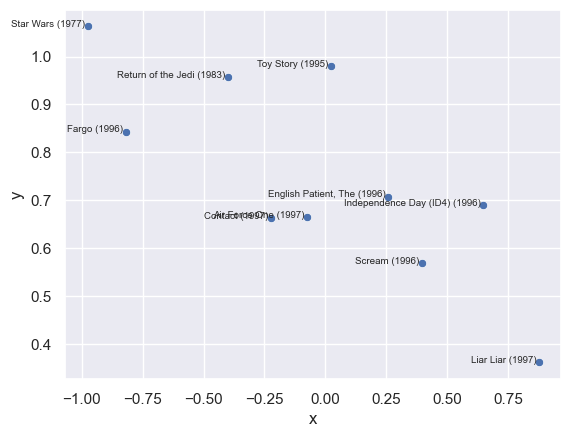

In [47]:
most_popular_data = pd.DataFrame(Vt[:,most_popular-1].T, columns=['x', 'y'])
most_popular_data.insert(2, 'name', most_popular_labels, True)
print(most_popular_data)
sns.scatterplot(data=most_popular_data, x='x', y='y')

for i in range(len(most_popular_data)):
    plt.text(most_popular_data['x'][i] - 0.01, most_popular_data['y'][i], \
             most_popular_data['name'][i], fontsize=7, ha='right')

          x         y                                               name
0  0.110093  0.368550                                 Prefontaine (1997)
1  0.452111 -0.127529                          Santa with Muscles (1996)
2 -0.234231 -0.046487                      Great Day in Harlem, A (1994)
3  0.008458 -0.039511                               Aiqing wansui (1994)
4 -0.008844 -0.202943                                    Star Kid (1997)
5  0.296528 -0.139845                      Someone Else's America (1995)
6 -0.073528 -0.227958  Entertaining Angels: The Dorothy Day Story (1996)
7 -0.049354  0.380410               Saint of Fort Washington, The (1993)
8 -0.449701 -0.010031                     They Made Me a Criminal (1939)
9  0.478933  0.579210         Marlene Dietrich: Shadow and Light (1996) 


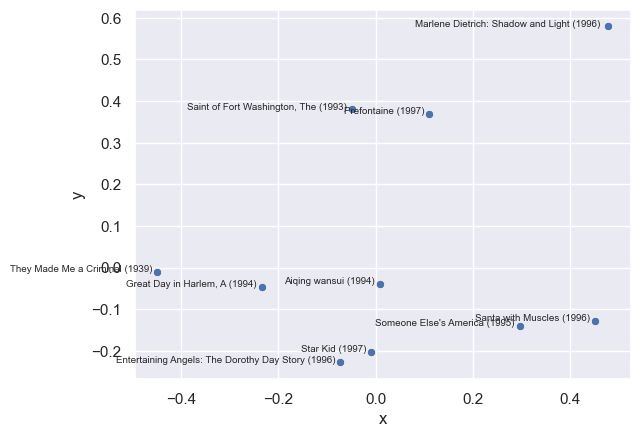

In [48]:
best_data = pd.DataFrame(Vt[:,best-1].T, columns=['x', 'y'])
best_data.insert(2, 'name', best_labels, True)
print(best_data)
sns.scatterplot(data=best_data, x='x', y='y')

for i in range(len(best_data)):
    plt.text(best_data['x'][i] - 0.01, best_data['y'][i], \
             best_data['name'][i], fontsize=7, ha='right')

          x         y                        name
0  0.024360  0.787497        Jurassic Park (1993)
1  0.138820  0.821161  Sound of Music, The (1965)
2  0.451276  0.662186              Top Gun (1986)
3  0.937252  0.144929       Batman Returns (1992)
4 -0.046650  0.784694         Men in Black (1997)
5 -0.868639  0.729217    Good Will Hunting (1997)
6  0.395924  0.567530               Scream (1996)
7  0.122403  0.698139               Batman (1989)
8 -0.928746  1.067195     Schindler's List (1993)
9  0.177387  0.573350        Koyaanisqatsi (1983)


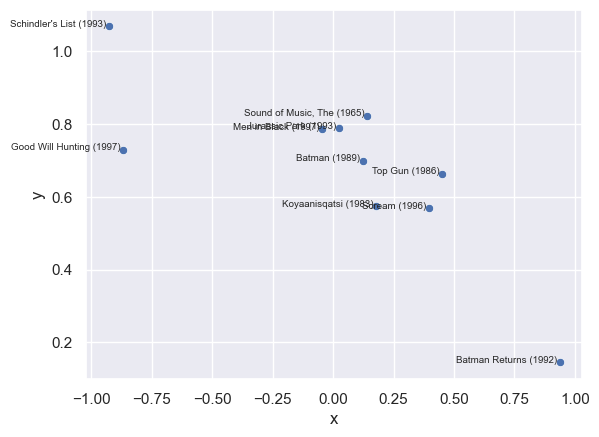

In [49]:
movie_id1 = np.array([82, 143, 161, 231, 257, 272, 288, 403, 318, 1065])
labels1 = movies.loc[movies['Movie ID'].isin(movie_id1)]["Movie Title"]
labels1 = labels1[movie_id1 - 1].to_numpy()

selected_data = pd.DataFrame(Vt[:,movie_id1-1].T, columns=['x', 'y'])
selected_data.insert(2, 'name', labels1, True)
print(selected_data)
sns.scatterplot(data=selected_data, x='x', y='y')

for i in range(len(selected_data)):
    plt.text(selected_data['x'][i] - 0.01, selected_data['y'][i], \
             selected_data['name'][i], fontsize=7, ha='right')
    
# In the figure below, left is fictional vs. right is historical
# Bottom is light-hearted, top is profound/deep/requires interpretation

          x         y                             name
0 -0.942563  0.883404            Godfather, The (1972)
1 -0.780839  1.022522   Raiders of the Lost Ark (1981)
2  0.647520  0.689299    Independence Day (ID4) (1996)
3 -0.819639  0.952061                   Titanic (1997)
4 -0.073456  0.663811             Air Force One (1997)
5 -0.399673  0.956386        Return of the Jedi (1983)
6 -0.976256  1.062993                 Star Wars (1977)
7  0.775211  0.353787       From Dusk Till Dawn (1996)
8  0.074747  0.640941  Star Trek: First Contact (1996)
9 -0.728346  1.034626  Empire Strikes Back, The (1980)


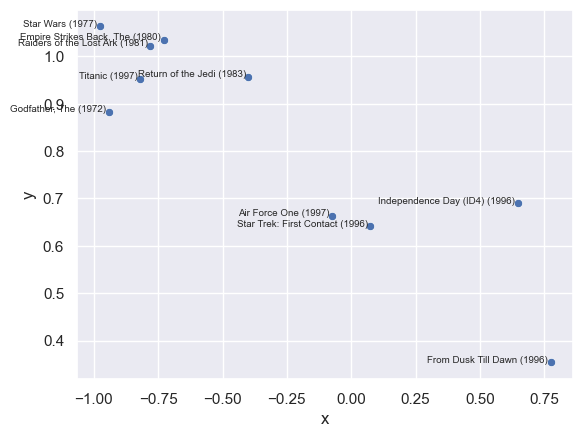

In [50]:
# Action

movie_id1 = np.array([127, 174, 121, 313, 300, 181, 50, 17, 222, 172])
labels1 = movies.loc[movies['Movie ID'].isin(movie_id1)]["Movie Title"]
labels1 = labels1[movie_id1 - 1].to_numpy()

selected_data = pd.DataFrame(Vt[:,movie_id1-1].T, columns=['x', 'y'])
selected_data.insert(2, 'name', labels1, True)
print(selected_data)
sns.scatterplot(data=selected_data, x='x', y='y')

for i in range(len(selected_data)):
    plt.text(selected_data['x'][i] - 0.01, selected_data['y'][i], \
             selected_data['name'][i], fontsize=7, ha='right')
    
# In the figure below, left is fictional vs. right is historical
# Bottom is light-hearted, top is profound/deep/requires interpretation

          x         y                                          name
0 -0.456097  0.766407                    Princess Bride, The (1987)
1  0.876010  0.360708                              Liar Liar (1997)
2  0.490584  0.606305                          Birdcage, The (1996)
3 -0.122142  0.777500                        Full Monty, The (1997)
4 -0.164818  0.856176  Willy Wonka and the Chocolate Factory (1971)
5 -0.150759  0.810895                           Forrest Gump (1994)
6 -0.432237  0.687747        Monty Python and the Holy Grail (1974)
7 -0.075714  0.793447                     Back to the Future (1985)
8  0.023745  0.979628                              Toy Story (1995)
9 -0.046650  0.784694                           Men in Black (1997)


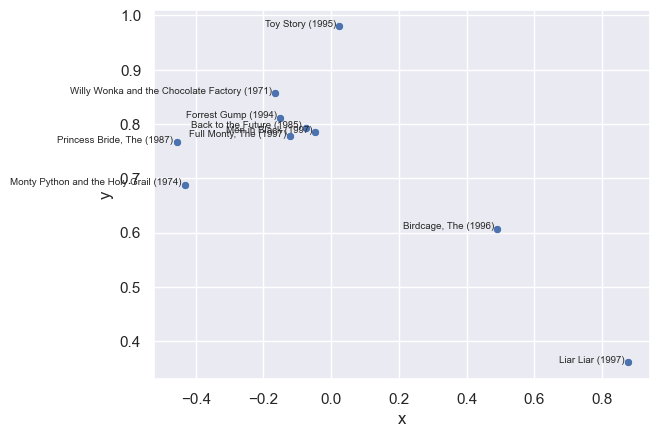

In [51]:
# Comedy

movie_id1 = np.array([173, 294, 25, 269, 151, 69, 168, 204, 1, 257])
labels1 = movies.loc[movies['Movie ID'].isin(movie_id1)]["Movie Title"]
labels1 = labels1[movie_id1 - 1].to_numpy()

selected_data = pd.DataFrame(Vt[:,movie_id1-1].T, columns=['x', 'y'])
selected_data.insert(2, 'name', labels1, True)
print(selected_data)
sns.scatterplot(data=selected_data, x='x', y='y')

for i in range(len(selected_data)):
    plt.text(selected_data['x'][i] - 0.01, selected_data['y'][i], \
             selected_data['name'][i], fontsize=7, ha='right')
    
# In the figure below, left is fictional vs. right is historical
# Bottom is light-hearted, top is profound/deep/requires interpretation

          x         y                                      name
0  0.166701  0.012682  Microcosmos: Le peuple de l'herbe (1996)
1 -0.314798  0.322428                              Crumb (1994)
2 -0.526284  0.783963                        Hoop Dreams (1994)
3 -0.103511  0.398175                   Paris Is Burning (1990)
4 -0.511262  0.594253                 When We Were Kings (1996)
5  0.110959  0.738446                Looking for Richard (1996)
6  0.200402 -0.099837       Fast, Cheap & Out of Control (1997)
7  0.177387  0.573350                      Koyaanisqatsi (1983)
8  0.343980  0.459645                  Dolores Claiborne (1994)
9  0.192468  0.379038                   Mighty Aphrodite (1995)


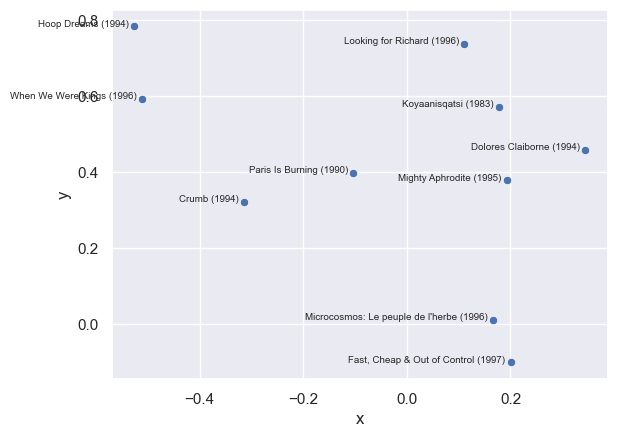

In [52]:
# Documentary

movie_id1 = np.array([634, 32, 48, 645, 1142, 847, 1022, 1065, 44, 13])
labels1 = movies.loc[movies['Movie ID'].isin(movie_id1)]["Movie Title"]
labels1 = labels1[movie_id1 - 1].to_numpy()

selected_data = pd.DataFrame(Vt[:,movie_id1-1].T, columns=['x', 'y'])
selected_data.insert(2, 'name', labels1, True)
print(selected_data)
sns.scatterplot(data=selected_data, x='x', y='y')

for i in range(len(selected_data)):
    plt.text(selected_data['x'][i] - 0.01, selected_data['y'][i], \
             selected_data['name'][i], fontsize=7, ha='right')
    
# In the figure below, left is fictional vs. right is historical
# Bottom is light-hearted, top is profound/deep/requires interpretation

### Star Wars and Godfather

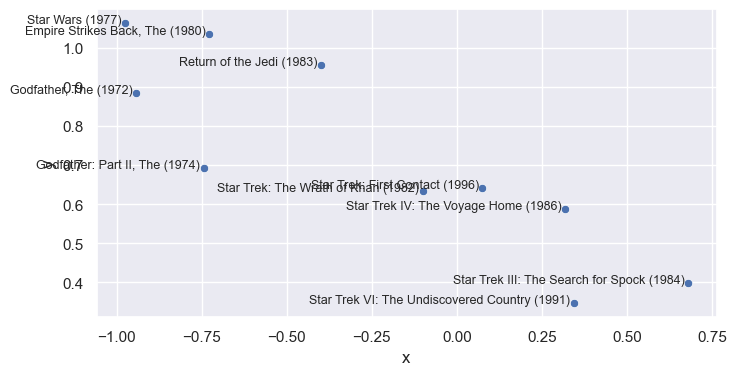

In [59]:
# Sample data
movie_id1 = np.array([50, 181, 172, 222, 227, 228, 229, 230,127,187])
labels1 = movies.loc[movies['Movie ID'].isin(movie_id1)]["Movie Title"]
labels1 = labels1[movie_id1 - 1].to_numpy()

selected_data = pd.DataFrame(Vt[:, movie_id1 - 1].T, columns=['x', 'y'])
selected_data.insert(2, 'name', labels1, True)

# Increase figure height
plt.figure(figsize=(8, 4))

# Scatter plot
sns.scatterplot(data=selected_data, x='x', y='y')

# Adjust text labels
for i in range(len(selected_data)):
    plt.text(selected_data['x'][i] - 0.01, selected_data['y'][i], \
             selected_data['name'][i], fontsize=9, ha='right')

plt.show()